In [73]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.external as sce
import seaborn as sns
from matplotlib.pyplot import rc_context
import matplotlib.patches as mpatches
import pickle
import gseapy as gp
from scipy import stats

In [45]:
# import rna obj with pseudotime annotation
rna = sc.read('../data/preprocessed_data/rna_pseudotime.h5')
rna.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,sample,leiden,Ig,IgL,IgH,sec,dpt_pseudotime,distance,time3
AAACCCAAGTACTGTC-1-0,3128,3128,21325.0,909.0,4.262603,0,1,G,kappa,G1,x,0.884599,0.884599,t0
AAACCCAAGTGAATAC-1-0,1774,1774,6060.0,518.0,8.547854,0,3,M,kappa,M,x,0.933548,0.933548,t2
AAACCCAGTCCACAGC-1-0,2914,2914,19771.0,792.0,4.005867,0,1,G,kappa,G1,hi,0.906659,0.906659,t1
AAACCCATCACAGTGT-1-0,3122,3122,12608.0,757.0,6.004125,0,1,M,kappa,M,hi,0.783142,0.783142,0
AAACCCATCCCTCTCC-1-0,3021,3021,16684.0,247.0,1.480460,0,1,G,kappa,G1,hi,0.892763,0.892763,t0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCGACTCCT-1-2,2467,2467,14874.0,309.0,2.077451,2,7,M,lambda,M,x,0.934061,0.934061,t2
TTTGTTGAGGTACAAT-1-2,2159,2159,14240.0,170.0,1.193820,2,7,M,lambda,M,x,0.947517,0.947517,t2
TTTGTTGAGTAACGAT-1-2,2665,2665,18230.0,674.0,3.697202,2,5,A,kappa,A,lo,0.915166,0.915166,t1
TTTGTTGCACGTTGGC-1-2,2211,2211,19481.0,384.0,1.971151,2,5,A,kappa,A,lo,0.968185,0.968185,t3


In [101]:
# add secreted IgG (IgG_ADT) to metadata

## igg_dict stores log1p counts of IgG_ADT per cell id (stored in rna.raw.X (includes IgG_ADT log(counts))_
igg_dict = dict(zip(rna.obs.index.tolist(), rna.raw.obs_vector('IgG_ADT').tolist()))

## add igg_adt to metadata
rna.obs['IgG_ADT'] = [igg_dict[i] for i in rna.obs.index.tolist()]

/var/folders/bm/jsmvb47d0nn6z2lrn12ymbvm0000gn/T/ipykernel_71636/306601783.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rna.obs['IgG_ADT'] = [igg_dict[i] for i in rna.obs.index.tolist()]


In [108]:
# with rc_context({'figure.figsize': (4, 4)}):
#     sc.pl.umap(rna, color=["IgG_ADT"],palette='plasma')

In [6]:
# import secRecon genesets, ontology
with open('../data/gene_dict.pkl', 'rb') as f:
    gene_dict = pickle.load(f)
    
with open('../data/process_dict.pkl', 'rb') as f:
    process_dict = pickle.load(f)

In [8]:
gene_dict[[*gene_dict][0]]

{'systems': ['Post-translational modifications'],
 'subsystems': ['Glycosylation'],
 'processes': ['Glycosphingolipid'],
 'subprocesses': ['Isoglobo series'],
 'subcellular_localization': ['Golgi'],
 'protein_complex': ['']}

In [36]:
# get all secRecon terms
terms0 = []

for g in [*gene_dict]:
    for i in ['systems','subsystems','processes','subprocesses']:
        terms0.extend(gene_dict[g][i]) 
sr_terms = list(set(terms0))

# create secRecon term2gene dictionary
t2g_dict = {}
for i in sr_terms:
    t2g_dict[i] = []
    
    
for g in [*gene_dict]:
    g_terms0 = []
    for i in ['systems','subsystems','processes','subprocesses']:
        g_terms0.extend(gene_dict[g][i]) 
        
    g_terms1 = list(set(g_terms0))
    
    for t in g_terms1:
        t2g_dict[t].append(g)

In [44]:
# save term2gene as pkl
with open('../data/t2g_dict.pickle', 'wb') as f:
    pickle.dump(t2g_dict,f)

# Geneset Avg Expression scoring
- score average expression for secRecon genesets and specific GO-BP genesets

In [46]:
# score Average expression of each secRecon geneset/subsystem
## store in metadata .obs
for i in [*t2g_dict]:
    sc.tl.score_genes(rna, t2g_dict[i], score_name=i+'_score')

In [89]:
# import GO-BP geneset from MSigDB
## c5.go.bp.v2023.2.Hs.symbols

gobp = gp.read_gmt(path="../data/c5.go.bp.v2023.2.Hs.symbols.gmt")
len(gobp)

7647

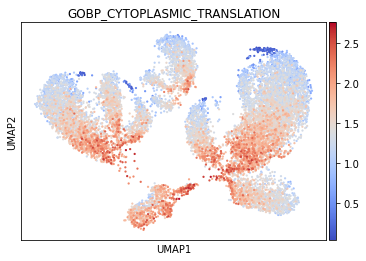

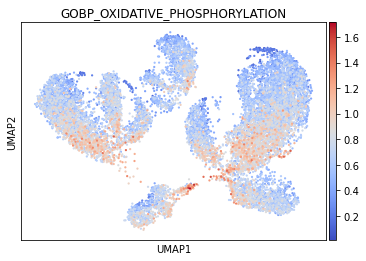

In [90]:
# score GOBP terms for translation and oxidative phosphorylation
# [i for i in [*gobp] if 'CYTOPLASMIC_TRANSLATION' in i or 'OXIDATIVE_PHOSPHORYLATION' in i]
goterms = ['GOBP_CYTOPLASMIC_TRANSLATION','GOBP_OXIDATIVE_PHOSPHORYLATION']

# avg score gobp terms
for c in [*goterms]:
    sc.tl.score_genes(rna, gobp[c], score_name=c)
    sc.pl.umap(rna, color=c, cmap="coolwarm", s=20)

In [91]:
# score overall IGH and IGL expression
# get IGH and IGL genes
ig_genes = {'hc': ['IGHG1','IGHG2','IGHG3','IGHG4'],
           'lc': ['IGKC','IGLC1','IGLC2','IGLC3']}

# avg score for hc/lc genes
for c in [*ig_genes]:
    sc.tl.score_genes(rna, ig_genes[c], score_name=c+'_avgexpr')

# Score PPI activity
- score PPI activity for secRecon subsystems using PPI edgelist
- PPI activity quantitative score derived from Origins2 mass-action based calculation (https://github.com/danielasenraoka/ORIGINS2 doi: 10.1016/j.mex.2023.102179)

In [ ]:
# score relative PPI activity per subsystem
## to-do--try with STRING? at least prep the tables from R to do this
## also need to update the PCNet PPI with updated secRecon genes -- done in R.
## push .R file for this into git

In [68]:
# in order to score PPI, extract single-cell normalized expression table for secRecon genes

## find secRecon genes in dataset
srg_expr = list(set([*gene_dict]) & set(rna.var.index.tolist()))
print(len(srg_expr),'secRecon genes in data') # 1100/1127 secrecon genes in data

# get rna_prod.X df for secrecon genes
rna_sr_expr = sc.get.obs_df(rna, keys=srg_expr) # cells x gene
rna_sr_expr.shape, rna_sr_expr.min().min(), rna_sr_expr.max().max()

1100 secRecon genes in data


((12892, 1100), 0.0, 5.76070499420166)

In [110]:
# export secrecon gene expression table
rna_sr_expr.to_pickle('../data/sc_secRecon_expr.pkl')

In [56]:
# import all pcnet, string ppi edgelist created from 0a_extract_ppi_network.Rmd script
pcnet_df = pd.read_csv('../data/ppi_db/networks/PCNet_edgelist.csv')[['V1','V2']]
string_df = pd.read_csv('../data/ppi_db/networks/STRINGdb_edgelist.csv')[['V1','V2']]
pcnet_df.shape, string_df.shape
# string_df

((2693250, 2), (236930, 2))

In [ ]:
# we will use PCNet as PPI network as it provides a parsimonious/consensus network and has been demonstrated to increase performance, improve geneset recovery
## 10.1016/j.cels.2018.03.001

In [59]:
# function to extract subgraph for a given list of genes based on full edge list; adapted from origins2
## this extracts secM-secM interactions only
## adapted from origins2 build_ppin.R function https://github.com/danielasenraoka/ORIGINS2 doi: 10.1016/j.mex.2023.102179
def build_ppin(genes_bp, ppi_edges_complete):
    genes_bp = list(set(genes_bp))
    
    # sequential filtering since both nodes per edge need to be secMs 
    ## using a combined OR statement would widen the subgraph to all interacting partners if desired in the future
    ##  such as ppi=ppi_edges_complete[(ppi_edges_complete['V1'].isin(genes_bp)) | (ppi_edges_complete['V2'].isin(genes_bp))]
    ppi = ppi_edges_complete[ppi_edges_complete.iloc[:, 0].isin(genes_bp)].copy()
    ppi = ppi[ppi.iloc[:, 1].isin(genes_bp)]
    ppi_df = pd.DataFrame(ppi)
    
    ppi_df['tuple'] = ppi_df.apply(lambda x: tuple(sorted(x)), axis=1)
    ppi_df_unique = ppi_df.drop_duplicates('tuple') # remove duplicate edges, though shouldnt be any based on source graph
    ppi_df_unique.reset_index(drop=True, inplace=True)
    ppi_df_unique = ppi_df_unique[['V1','V2']]
    ppi_df_unique.columns = ['node1','node2']

    return ppi_df_unique

# function to calculate ppi activity per cell (column); adapted from origins2

def activity(expression_matrix, adjacency_edges, normalization=True):
    if not isinstance(normalization, bool):
        raise ValueError("Normalization must be logical")

    ppi_df = pd.DataFrame(adjacency_edges, columns=["node1", "node2"])
    reduced_df = pd.DataFrame(expression_matrix)
    reduced_df = reduced_df.sort_index(axis=0)
    
    intersection_genes = set(reduced_df.index) & set(ppi_df["node1"]) # does this include all?
    ppi_df_reduced = ppi_df[ppi_df["node1"].isin(intersection_genes)]
    ppi_df_reduced = ppi_df_reduced[ppi_df_reduced["node2"].isin(intersection_genes)]
    
    n_edges = ppi_df_reduced.shape[0]
    adjacency_list = ppi_df_reduced.groupby("node2")["node1"].apply(list).reset_index()
    adjacency_list.set_index("node2", inplace=True)
    
    act = np.zeros(reduced_df.shape[1]) # init array of n cells
    
    for cell in range(reduced_df.shape[1]):

        sum_expression = 0
        for gene_name, neighbors in adjacency_list.iterrows():
            sum_expression += (reduced_df.loc[gene_name, reduced_df.columns[cell]] * sum(reduced_df.loc[neighbors["node1"], reduced_df.columns[cell]]))
        act[cell] = sum_expression
    
    if normalization:
        act /= n_edges
    
    return act

In [60]:
# build PPI network (subsystem's edge df); if there are more than 3 edges per graph
sr_ppin = {}
for ss in [*t2g_dict]:
    ss_ppi = build_ppin(t2g_dict[ss],pcnet_df)
    if ss_ppi.shape[0] > 3:
        sr_ppin[ss] = ss_ppi

In [61]:
# repeat for STRINGdb ppi
sr_ppin_string = {}
for ss in [*t2g_dict]:
    ss_ppi = build_ppin(t2g_dict[ss],string_df)
    if ss_ppi.shape[0] > 3:
        sr_ppin_string[ss] = ss_ppi

In [63]:
[print(s,sr_ppin[s].shape[0]) for s in [*sr_ppin]]

Proteostasis 11419
Protein conformation 3261
Glycerophospholipid (GPI anchor) 127
COPII 178
Keratan sulfate 43
ER Ca Homeostasis 242
Retrotranslocation 235
O-glycan not-mucin 91
Mislocalized protein degradation 679
PERK pathway 59
O-glycan mucin 156
Multimerization 18
Apoptosis 283
IRE1 pathway 131
Phosphorylation 93
SLC nucleotide-sugar transporter 59
Vesicle trafficking 11557
Kinase 88
Endocytosis 1181
Post-translational modifications 3825
Lysosomal degradation/Glyco-conjugate degradation 58
ER stress response/UPR 995
COPI 297
Autophagy (Vesicle trafficking) 493
Post-Golgi 3927
Globo series 13
Protein folding 2925
Targeting to correct compartment/cargo sorting 410
Clathrin 93
Proteasomal degradation 1633
Lacto/neolacto series 174
Autophagy (Proteostasis) 148
N-glycan 386
Chondroitin sulfate 103
O-glycan 416
Pre-Golgi 2376
Post-translational translocation 34
Ganglio series 61
Glycosaminoglycan 497
TRC pathway 7
ERpQC 4
Ubiquitination 1279
ERAD 6581
Golgi to ER (retrograde) 417
Vesicle

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [64]:
[print(s,sr_ppin_string[s].shape[0]) for s in [*sr_ppin_string]]

Proteostasis 2459
Protein conformation 696
Glycerophospholipid (GPI anchor) 182
COPII 126
Keratan sulfate 14
ER Ca Homeostasis 81
Retrotranslocation 126
O-glycan not-mucin 80
Mislocalized protein degradation 562
PERK pathway 25
O-glycan mucin 101
Multimerization 5
Apoptosis 82
IRE1 pathway 48
Phosphorylation 19
SLC nucleotide-sugar transporter 17
Vesicle trafficking 2375
Kinase 19
Endocytosis 279
Post-translational modifications 949
Lysosomal degradation/Glyco-conjugate degradation 13
ER stress response/UPR 287
COPI 120
Autophagy (Vesicle trafficking) 259
Post-Golgi 1039
Globo series 15
Protein folding 617
Targeting to correct compartment/cargo sorting 128
Clathrin 30
Proteasomal degradation 1019
Lacto/neolacto series 135
Autophagy (Proteostasis) 28
N-glycan 214
Chondroitin sulfate 39
O-glycan 245
Pre-Golgi 704
Post-translational translocation 19
Ganglio series 18
Glycosaminoglycan 78
TRC pathway 9
Ubiquitination 272
ERAD 1782
Golgi to ER (retrograde) 181
Vesicle budding 34
Endocytic r

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [70]:
# calculate PPI activity per secrecon subsystem for sc data
rna_ppi = {}

for ss in [*sr_ppin]:
    if sr_ppin[ss].shape[0] > 1:
        rna_ppi[ss] = activity(rna_sr_expr.T,sr_ppin[ss],normalization=True)

rna_ppi_df = pd.DataFrame(np.row_stack([rna_ppi[i] for i in [*rna_ppi]]))
rna_ppi_df.index = [*rna_ppi]
rna_ppi_df.columns = rna_sr_expr.T.columns

In [69]:
# calculate PPI activity per secrecon subsystem for sc data (STRING)
rna_ppi_string = {}

for ss in [*sr_ppin_string]:
    if sr_ppin_string[ss].shape[0] > 1:
        rna_ppi_string[ss] = activity(rna_sr_expr.T,sr_ppin_string[ss],normalization=True)

rna_ppi_string_df = pd.DataFrame(np.row_stack([rna_ppi_string[i] for i in [*rna_ppi_string]]))
rna_ppi_string_df.index = [*rna_ppi_string]
rna_ppi_string_df.columns = rna_sr_expr.T.columns

In [86]:
# save these results
rna_ppi_df.to_pickle('../data/ppi_db/rna_ppi_pcnet.pkl')
rna_ppi_string_df.to_pickle('../data/ppi_db/rna_ppi_string.pkl')

In [92]:
# add PPI score to metadata for viz
for i in rna_ppi_df.T.columns:
    rna.obs[i+'_ppi'] = rna_ppi_df.T[i]

/var/folders/bm/jsmvb47d0nn6z2lrn12ymbvm0000gn/T/ipykernel_71636/3610316279.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rna.obs[i+'_ppi'] = rna_ppi_df.T[i]
/var/folders/bm/jsmvb47d0nn6z2lrn12ymbvm0000gn/T/ipykernel_71636/3610316279.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rna.obs[i+'_ppi'] = rna_ppi_df.T[i]
/var/folders/bm/jsmvb47d0nn6z2lrn12ymbvm0000gn/T/ipykernel_71636/3610316279.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

In [93]:
rna.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,sample,leiden,Ig,IgL,IgH,...,Disulfide bond formation_ppi,Membrane fusion_ppi,Translocation_ppi,Co-translational translocation_ppi,Lysosomes_ppi,Cytoskeletal remodeling_ppi,Golgi organization_ppi,Glycosphingolipid_ppi,Glycosylation_ppi,ATF6 pathway_ppi
AAACCCAAGTACTGTC-1-0,3128,3128,21325.0,909.0,4.262603,0,1,G,kappa,G1,...,0.265248,0.046458,1.616409,1.819897,0.013196,0.371228,0.016733,0.015527,0.024130,0.000000
AAACCCAAGTGAATAC-1-0,1774,1774,6060.0,518.0,8.547854,0,3,M,kappa,M,...,0.022169,0.008631,0.585010,0.679862,0.015434,0.120019,0.000000,0.000000,0.011048,0.000000
AAACCCAGTCCACAGC-1-0,2914,2914,19771.0,792.0,4.005867,0,1,G,kappa,G1,...,0.539504,0.031771,2.141757,2.476017,0.018696,0.453853,0.000000,0.001241,0.022662,0.000000
AAACCCATCACAGTGT-1-0,3122,3122,12608.0,757.0,6.004125,0,1,M,kappa,M,...,0.287641,0.060718,0.874003,0.876605,0.099396,0.281816,0.000000,0.044770,0.022601,0.000000
AAACCCATCCCTCTCC-1-0,3021,3021,16684.0,247.0,1.480460,0,1,G,kappa,G1,...,0.263365,0.022913,1.355246,1.435594,0.068564,0.363887,0.025068,0.009090,0.022926,0.419445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCGACTCCT-1-2,2467,2467,14874.0,309.0,2.077451,2,7,M,lambda,M,...,0.089205,0.041414,0.949896,0.663635,0.028876,0.304052,0.000000,0.002596,0.009699,0.000000
TTTGTTGAGGTACAAT-1-2,2159,2159,14240.0,170.0,1.193820,2,7,M,lambda,M,...,0.101478,0.009241,1.021262,0.971451,0.016065,0.172519,0.032446,0.000000,0.011484,0.319740
TTTGTTGAGTAACGAT-1-2,2665,2665,18230.0,674.0,3.697202,2,5,A,kappa,A,...,0.092317,0.030299,1.147316,1.325469,0.029162,0.361583,0.000000,0.003031,0.009523,0.000000
TTTGTTGCACGTTGGC-1-2,2211,2211,19481.0,384.0,1.971151,2,5,A,kappa,A,...,0.065533,0.013444,1.040153,1.154902,0.006553,0.193638,0.000000,0.000000,0.005915,0.000000


In [94]:
# save rna obj ## last save 080424 with final secrecon genesets
rna.write('../data/preprocessed_data/rna_pseudotime_ppiscore.h5')

In [ ]:
# visualize ppi scoring overlay on UMAP
# for i in [*sr_ppin]:
#     if i+'_ppi' in rna.obs.columns:
#         maxabs = max(abs(rna.obs[i+'_ppi']))
#         minabs = min(abs(rna.obs[i+'_ppi']))
#         try:
#             sc.pl.umap(rna, color=i+'_ppi', cmap="coolwarm", s=20, vmin=minabs, vmax=maxabs)
#         except:
#             print(i)

# prepare data for Dominance Analysis

In [95]:
# create df to assess IgG variance; pseudotime variance explained by child secrecon subsystem avg expression; ppis
## in aggregate and per cluster? cell type?


### group columns of interest
cols_meta = ['leiden','Ig','IgL','IgH','sec','sample']
cols_response = ['dpt_pseudotime','IgG_ADT']
cols_scores = [i for i in rna.obs.columns if 'score' in i]
cols_ppi = [i for i in rna.obs.columns if 'ppi' in i]

cols_gobp = [i for i in rna.obs.columns if 'GOBP' in i]
cols_transcription = ['hc_avgexpr']

In [109]:
# export df
rna.obs[cols_meta+cols_response+cols_scores+cols_ppi+cols_gobp+cols_transcription].to_pickle('../data/dominance_analysis/rna_pseudotime_ppiscore_relimp-input.pkl')